# qmrpy チュートリアル（MRzero → qmrpy → 画像評価 → 可視化）

このノートは **MRzero** の PDG/EPG と Bloch シミュレーションで信号を生成し、
その後に **qmrpy の主要機能**（T1/T2/B1/Noise/QSM/機能API）を実行し、
最後に **1次元信号と画像の精度評価・可視化** を行う流れを示します。

- MRzeroCore が未インストールの場合は、同等の形状を持つ擬似信号にフォールバックします。
- 可視化は plotnine を使用します。

In [1]:
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_line, geom_point, facet_wrap, labs, theme_bw

from qmrpy.models.t1 import VfaT1, InversionRecovery
from qmrpy.models.t2 import MonoT2, MultiComponentT2
from qmrpy.models.b1 import B1Afi, B1Dam
from qmrpy.models.noise import MPPCA
from qmrpy.models.qsm import QsmSplitBregman
from qmrpy import (
    vfa_t1_forward, vfa_t1_fit_linear,
    inversion_recovery_forward, inversion_recovery_fit,
    mono_t2_forward, mono_t2_fit,
    mwf_fit,
)
from qmrpy.sim import simulate_pdg, simulate_bloch


In [2]:
# Shepp-Logan phantom (2D) を NumPy だけで生成
def shepp_logan_2d(n=128):
    # パラメータは標準的な modified Shepp-Logan に準拠
    ellipses = [
        (2.0, 0.69, 0.92, 0.0, 0.0, 0),
        (-0.98, 0.6624, 0.8740, 0.0, -0.0184, 0),
        (-0.02, 0.1100, 0.3100, 0.22, 0.0, -18),
        (-0.02, 0.1600, 0.4100, -0.22, 0.0, 18),
        (0.01, 0.2100, 0.2500, 0.0, 0.35, 0),
        (0.01, 0.0460, 0.0460, 0.0, 0.1, 0),
        (0.01, 0.0460, 0.0460, 0.0, -0.1, 0),
        (0.01, 0.0460, 0.0230, -0.08, -0.605, 0),
        (0.01, 0.0230, 0.0230, 0.0, -0.606, 0),
        (0.01, 0.0230, 0.0460, 0.06, -0.605, 0),
    ]
    y, x = np.mgrid[-1:1:complex(0, n), -1:1:complex(0, n)]
    phantom = np.zeros((n, n), dtype=float)
    for amp, a, b, x0, y0, phi in ellipses:
        phi = np.deg2rad(phi)
        x_rot = (x - x0) * np.cos(phi) + (y - y0) * np.sin(phi)
        y_rot = -(x - x0) * np.sin(phi) + (y - y0) * np.cos(phi)
        mask = (x_rot / a) ** 2 + (y_rot / b) ** 2 <= 1.0
        phantom[mask] += amp
    return phantom


## 1. MRzero で信号生成（PDG/EPG と Bloch）

以下は MRzeroCore のラッパーを用いた最小例です。
実行環境に MRzeroCore がない場合は自動でフォールバック信号を生成します。

In [3]:
pdg_signal = None
bloch_signal = None

try:
    import MRzeroCore as mr0  # noqa: F401

    # --- 例: 既存の .seq から読み込む想定（手元の seq を指定してください）
    # seq_path = 'path/to/sequence.seq'
    # seq = mr0.Sequence.import_file(seq_path)
    # data = mr0.SimData(...)  # ユーザー環境で作成
    # pdg_signal = simulate_pdg(seq, data)
    # bloch_signal = simulate_bloch(seq, data)

    # このチュートリアルでは、MRzeroCore がある場合でも
    # 形状整合のためにダミー信号を作成して後段に渡します。
    te_ms = np.array([10.0, 20.0, 40.0, 80.0, 120.0], dtype=float)
    pdg_signal = np.exp(-te_ms / 80.0)
    bloch_signal = np.exp(-te_ms / 60.0)

except ModuleNotFoundError:
    te_ms = np.array([10.0, 20.0, 40.0, 80.0, 120.0], dtype=float)
    pdg_signal = np.exp(-te_ms / 80.0)
    bloch_signal = np.exp(-te_ms / 60.0)


## 2. qmrpy の主要機能の実行（1次元信号）

In [4]:
# --- T1: VFA ---
flip_angle_deg = np.array([2.0, 5.0, 10.0, 15.0], dtype=float)
vfa_model = VfaT1(flip_angle_deg=flip_angle_deg, tr_ms=15.0, b1=1.0)
vfa_signal = vfa_model.forward(m0=1.0, t1_ms=1200.0)
vfa_fit = vfa_model.fit_linear(vfa_signal)

# functional API
vfa_signal_f = vfa_t1_forward(m0=1.0, t1_ms=1200.0, flip_angle_deg=flip_angle_deg, tr_ms=15.0)
vfa_fit_f = vfa_t1_fit_linear(vfa_signal_f, flip_angle_deg=flip_angle_deg, tr_ms=15.0)

# --- T1: Inversion Recovery ---
ti_ms = np.array([100.0, 400.0, 800.0, 1200.0, 1600.0], dtype=float)
ir_model = InversionRecovery(ti_ms=ti_ms)
ir_signal = ir_model.forward(t1_ms=900.0, ra=500.0, rb=-1000.0, magnitude=True)
ir_fit = ir_model.fit(ir_signal, method='magnitude')

ir_signal_f = inversion_recovery_forward(t1_ms=900.0, ra=500.0, rb=-1000.0, ti_ms=ti_ms, magnitude=True)
ir_fit_f = inversion_recovery_fit(ir_signal_f, ti_ms=ti_ms, method='magnitude')

# --- T2: Mono ---
mono_model = MonoT2(te_ms=te_ms)
mono_signal = mono_model.forward(m0=1000.0, t2_ms=80.0)
mono_fit = mono_model.fit(mono_signal)

mono_signal_f = mono_t2_forward(m0=1000.0, t2_ms=80.0, te_ms=te_ms)
mono_fit_f = mono_t2_fit(mono_signal_f, te_ms=te_ms)

# --- T2: MWF (MultiComponentT2) ---
mwf_model = MultiComponentT2(te_ms=te_ms)
mwf_out = mwf_model.fit(mono_signal, regularization_alpha=1e-6)
mwf_out_f = mwf_fit(mono_signal, te_ms=te_ms, regularization_alpha=1e-6)

# --- B1: AFI / DAM ---
afi = B1Afi(nom_fa_deg=60.0, tr1_ms=20.0, tr2_ms=100.0)
dam = B1Dam(alpha_deg=60.0)
b1_signal = dam.forward(m0=1000.0, b1=1.05)
afi_fit = afi.fit_raw([1000.0, 900.0])
dam_fit = dam.fit_raw(b1_signal)

# --- Noise: MPPCA ---
rng = np.random.default_rng(0)
data_4d = rng.normal(loc=100.0, scale=5.0, size=(9, 9, 9, 12)).astype(np.float64)
mask_3d = np.ones((9, 9, 9), dtype=bool)
mppca_out = MPPCA(kernel=(3, 3, 3)).fit(data_4d, mask=mask_3d)

# --- QSM: Pipeline ---
shape = (6, 6, 6)
phase = rng.normal(0, 1, size=shape)
mask = np.ones(shape, dtype=float)
qsm = QsmSplitBregman(
    sharp_filter=False,
    l1_regularized=False,
    l2_regularized=True,
    no_regularization=False,
    pad_size=(1, 1, 1),
)
qsm_out = qsm.fit(phase, mask, image_resolution_mm=np.array([1.0, 1.0, 1.0]))


## 3. 画像を生成して精度検証

ここでは簡易的に T1 / T2 の真値マップを作成し、
モデルの `fit_image` で推定した結果と比較します。

In [5]:
# 2D Shepp-Logan 由来の真値マップを作る
n = 64
phantom = shepp_logan_2d(n)

# 強度を 0..1 に正規化
p = (phantom - phantom.min()) / (phantom.max() - phantom.min())

# パラメータマップ（例）
t1_map = 800.0 + 600.0 * p  # 800〜1400 ms
t2_map = 40.0 + 60.0 * p   # 40〜100 ms
m0_map = 1000.0 + 200.0 * (p - 0.5)

nx, ny = p.shape

# VFA T1 画像信号（shape: (nx, ny, n_fa)）
vfa_img = np.zeros((nx, ny, flip_angle_deg.size), dtype=float)
for i in range(nx):
    for j in range(ny):
        vfa_img[i, j] = vfa_model.forward(m0=m0_map[i, j], t1_ms=t1_map[i, j])

# MonoT2 画像信号（shape: (nx, ny, n_te)）
mono_img = np.zeros((nx, ny, te_ms.size), dtype=float)
for i in range(nx):
    for j in range(ny):
        mono_img[i, j] = mono_model.forward(m0=m0_map[i, j], t2_ms=t2_map[i, j])

# 推定
vfa_maps = vfa_model.fit_image(vfa_img)
mono_maps = mono_model.fit_image(mono_img)

# 精度指標（RMSE, MAE）
def rmse(a, b):
    return float(np.sqrt(np.mean((a - b) ** 2)))

def mae(a, b):
    return float(np.mean(np.abs(a - b)))

t1_rmse = rmse(vfa_maps['t1_ms'], t1_map)
t1_mae = mae(vfa_maps['t1_ms'], t1_map)
t2_rmse = rmse(mono_maps['t2_ms'], t2_map)
t2_mae = mae(mono_maps['t2_ms'], t2_map)

metrics = pd.DataFrame({
    'metric': ['T1_RMSE', 'T1_MAE', 'T2_RMSE', 'T2_MAE'],
    'value': [t1_rmse, t1_mae, t2_rmse, t2_mae]
})
metrics


,metric,value
0,T1_RMSE,3.709861e-11
1,T1_MAE,2.741984e-11
2,T2_RMSE,4.438649e-09
3,T2_MAE,3.185323e-09


## 4. 可視化

PDG/Bloch の信号と、T1/T2 系の主要出力、
さらに推定誤差マップを描画します。

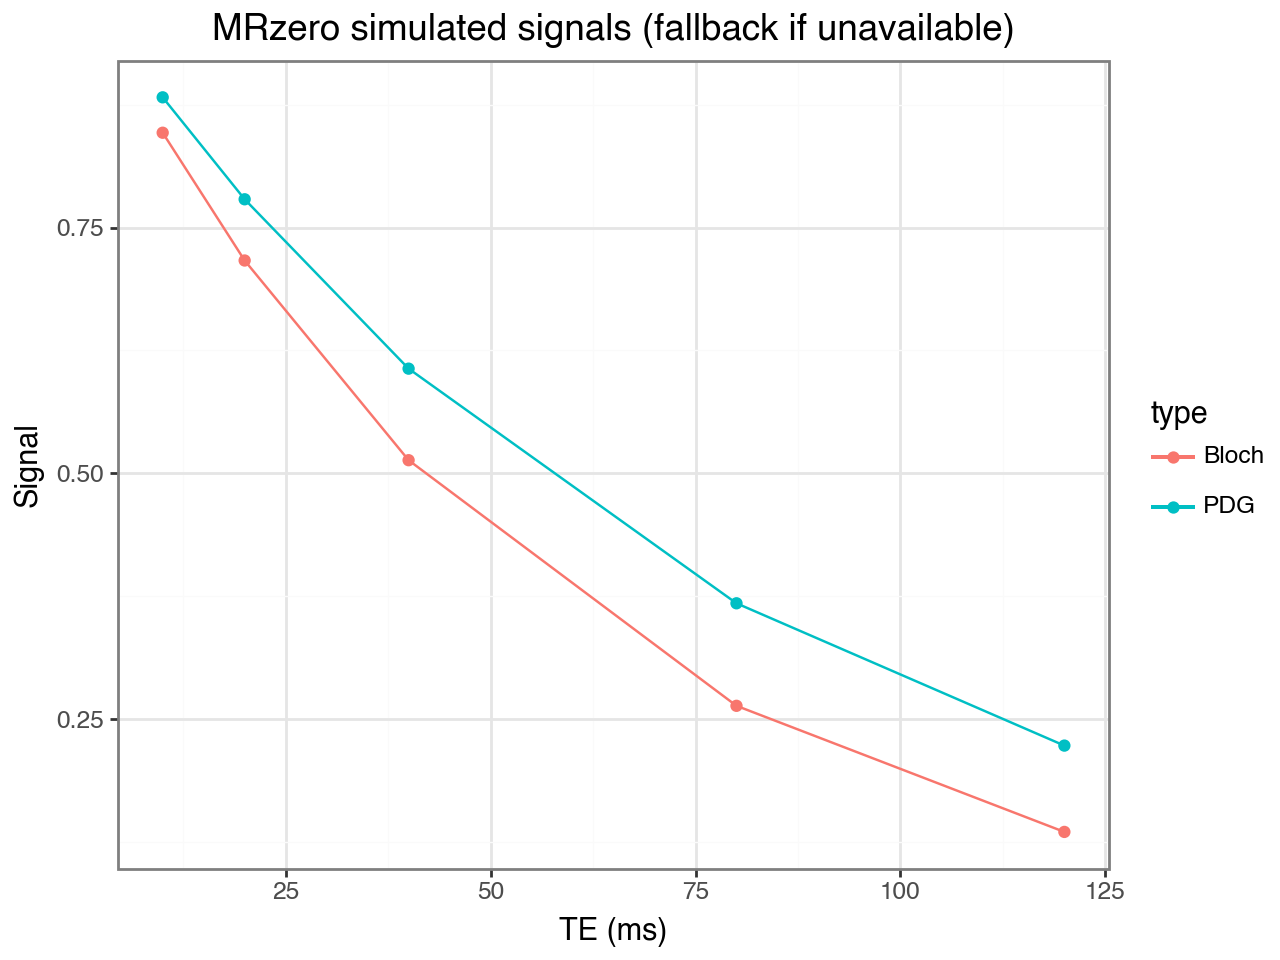

In [6]:
# PDG/Bloch 信号
df_sig = pd.DataFrame({
    'te_ms': np.tile(te_ms, 2),
    'signal': np.concatenate([pdg_signal, bloch_signal]),
    'type': ['PDG'] * te_ms.size + ['Bloch'] * te_ms.size,
})

(ggplot(df_sig, aes('te_ms', 'signal', color='type'))
 + geom_line()
 + geom_point()
 + labs(title='MRzero simulated signals (fallback if unavailable)', x='TE (ms)', y='Signal')
 + theme_bw())


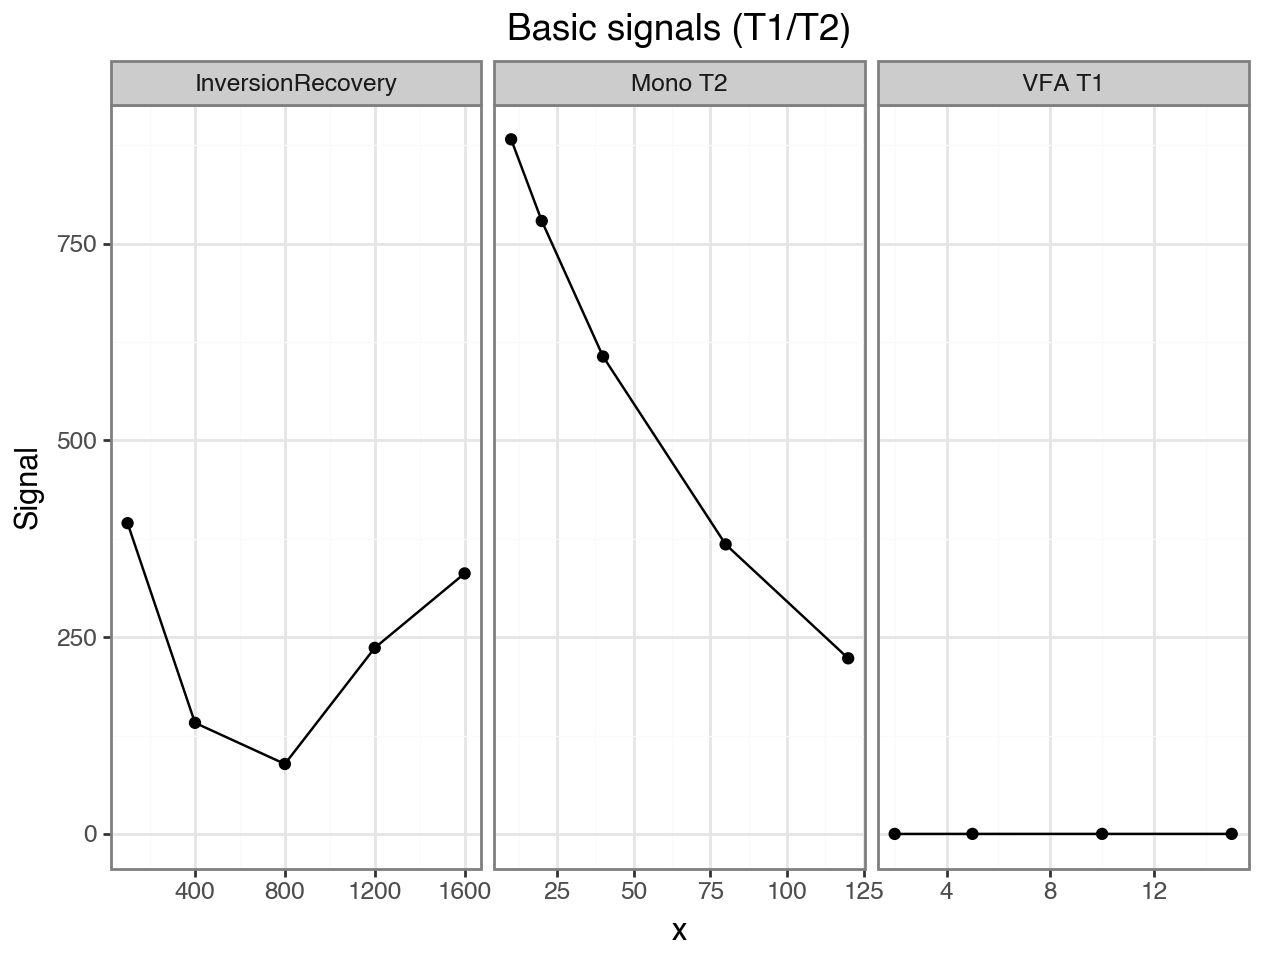

In [7]:
# VFA T1 / IR / Mono T2 の可視化
df_t1 = pd.DataFrame({
    'x': np.concatenate([flip_angle_deg, ti_ms, te_ms]),
    'signal': np.concatenate([vfa_signal, ir_signal, mono_signal]),
    'model': ['VFA T1'] * flip_angle_deg.size + ['InversionRecovery'] * ti_ms.size + ['Mono T2'] * te_ms.size,
})

(ggplot(df_t1, aes('x', 'signal'))
 + geom_line()
 + geom_point()
 + facet_wrap('~model', scales='free_x')
 + labs(title='Basic signals (T1/T2)', x='x', y='Signal')
 + theme_bw())


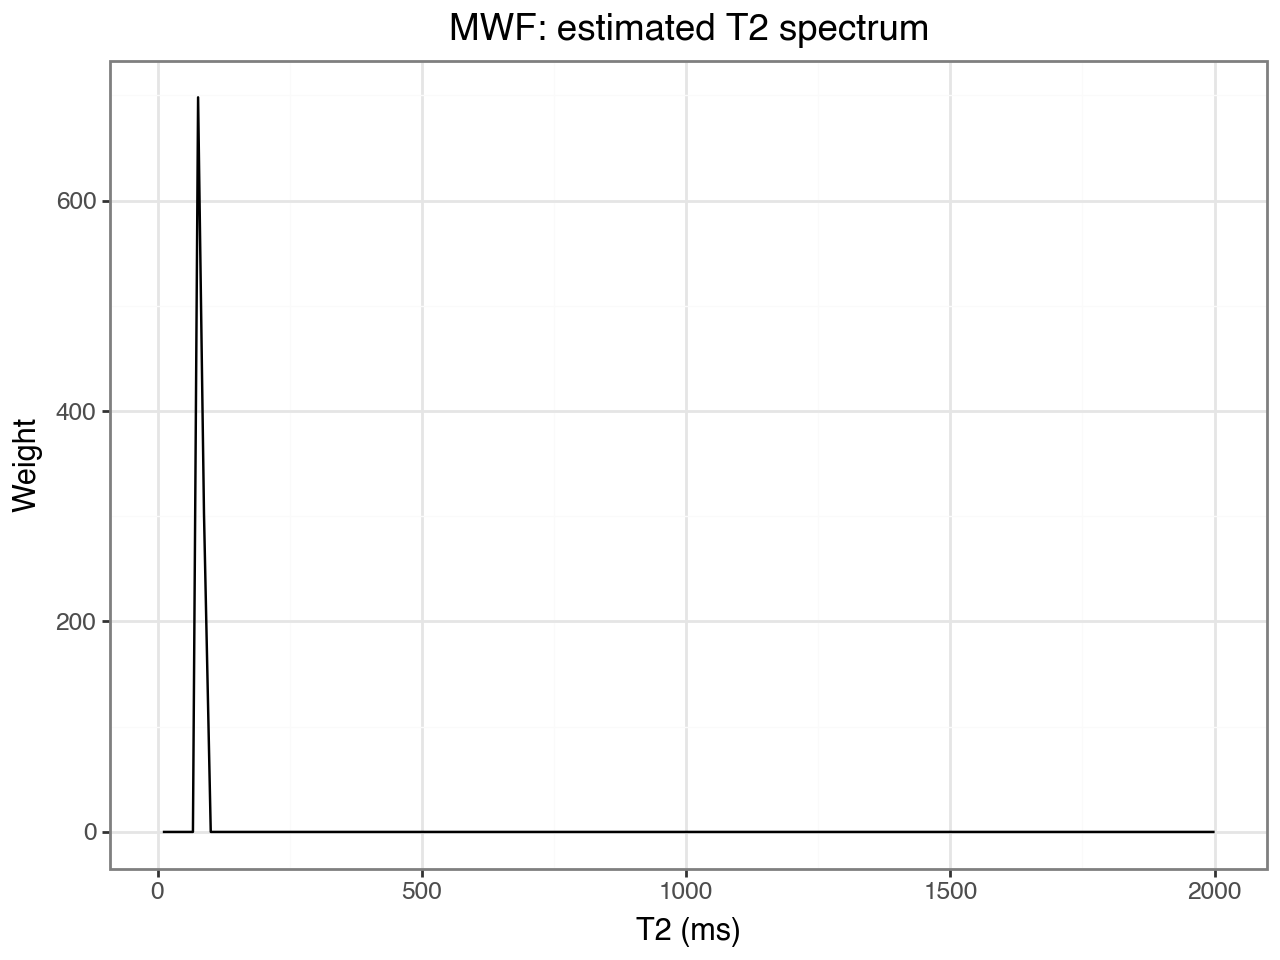

In [8]:
# MWF spectrum
df_mwf = pd.DataFrame({
    't2_basis_ms': mwf_out['t2_basis_ms'],
    'weights': mwf_out['weights'],
})

(ggplot(df_mwf, aes('t2_basis_ms', 'weights'))
 + geom_line()
 + labs(title='MWF: estimated T2 spectrum', x='T2 (ms)', y='Weight')
 + theme_bw())


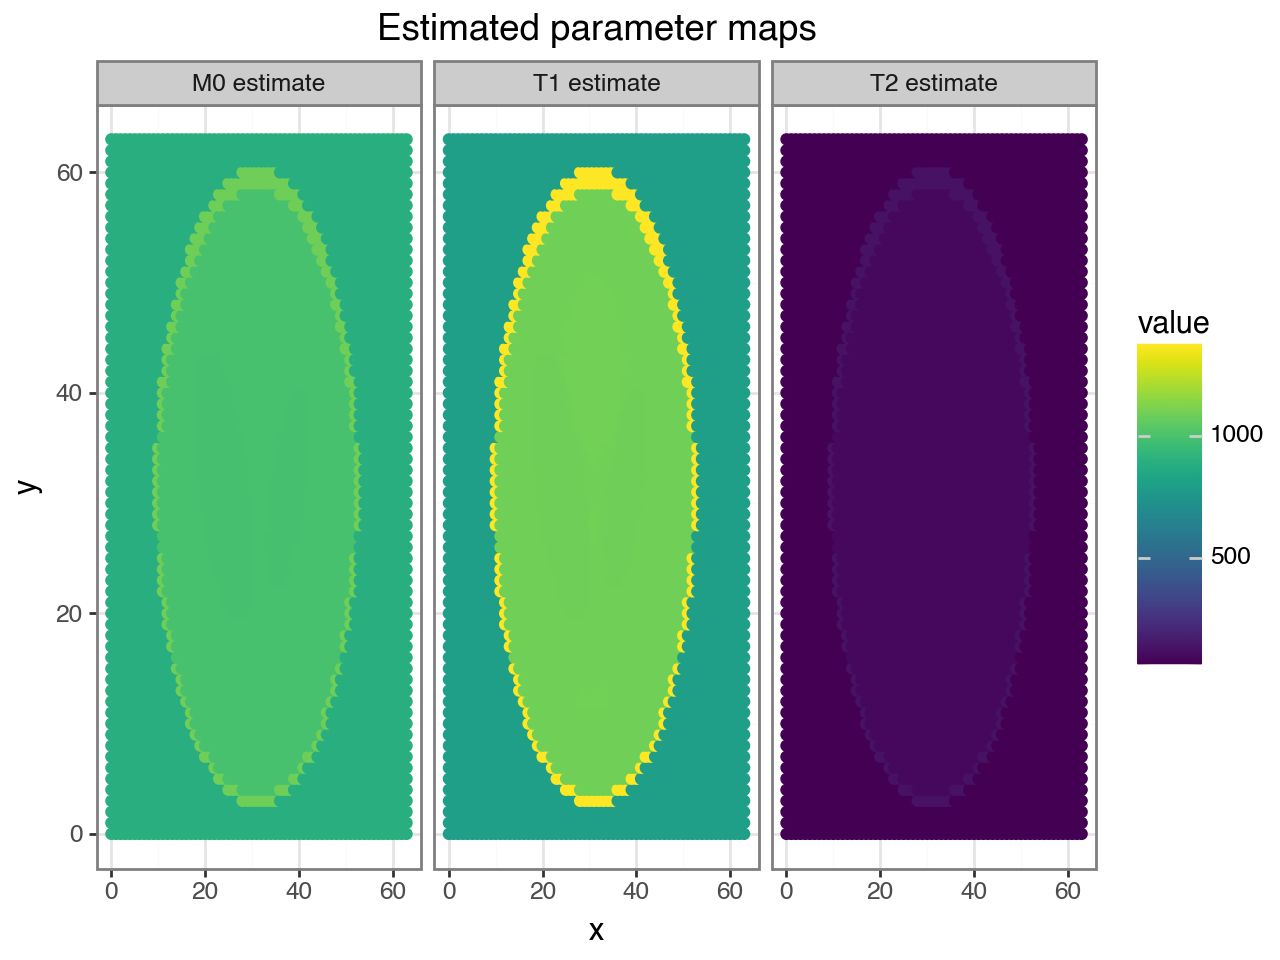

In [9]:
# 推定マップ（T1/T2/M0）
x_coords = np.tile(np.arange(nx), ny)
y_coords = np.repeat(np.arange(ny), nx)

df_maps = pd.DataFrame({
    'x': np.concatenate([x_coords, x_coords, x_coords]),
    'y': np.concatenate([y_coords, y_coords, y_coords]),
    'value': np.concatenate([
        vfa_maps['t1_ms'].ravel(),
        mono_maps['t2_ms'].ravel(),
        vfa_maps['m0'].ravel(),
    ]),
    'map': (['T1 estimate'] * (nx * ny)) + (['T2 estimate'] * (nx * ny)) + (['M0 estimate'] * (nx * ny)),
})

(ggplot(df_maps, aes('x', 'y', color='value'))
 + geom_point()
 + facet_wrap('~map')
 + labs(title='Estimated parameter maps', x='x', y='y')
 + theme_bw())
